# BOREx example

### import

In [1]:
import glob
import xml.etree.ElementTree as ET
import numpy as np
import pickle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
%matplotlib inline

from borex.borex    import *

### Set variables

In [2]:
# variables
start = 100
count = 5

from pathlib import Path
base_dir = os.path.abspath(Path().resolve())
dir_output          = os.path.join(base_dir, "result\\")
if not os.path.exists(dir_output):
    os.mkdir(dir_output)
path_config         = os.path.join(base_dir, "config.yaml")
dir_image           = os.path.join(base_dir, "voc_image\\")
dir_segmentation    = os.path.join(base_dir, "voc_segmentation\\")
fmt_annotation      = os.path.join(base_dir, "voc_annotation\\*.xml")
path_image_net      = os.path.join(base_dir, "voc_imagenet_trans.txt")

### Run

voc_class: horse
Deletion AUC    : 0.005508788897818663
Insertion AUC   : 0.3335274823516744
Recall AUC      : 0.8147309600883413
Precision AUC   : 0.23454835079257857
F-Value AUC     : 0.15786425701764495


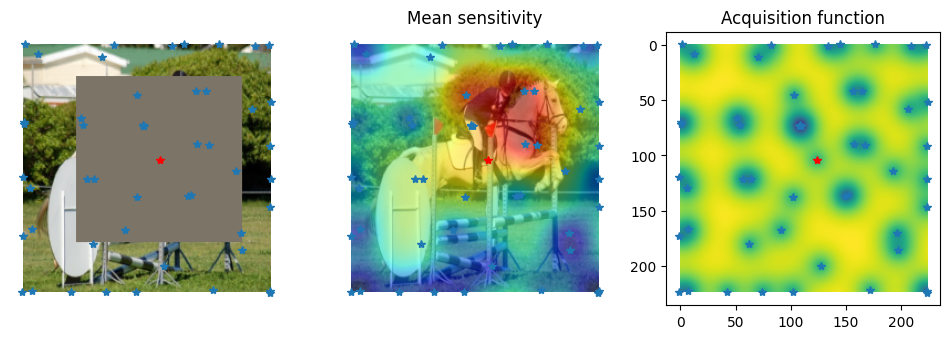

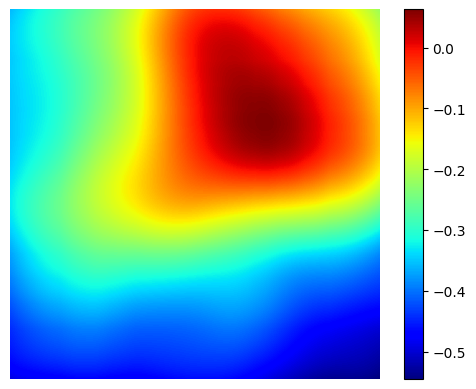

voc_class: bicycle
Deletion AUC    : 0.0013771779631025335
Insertion AUC   : 0.13779725440994234
Recall AUC      : 0.9601847650117739
Precision AUC   : 0.006903907054335021
F-Value AUC     : 0.006340242529256589


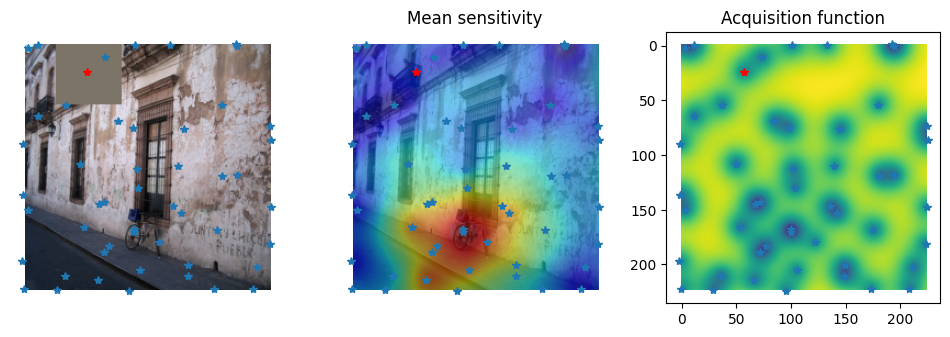

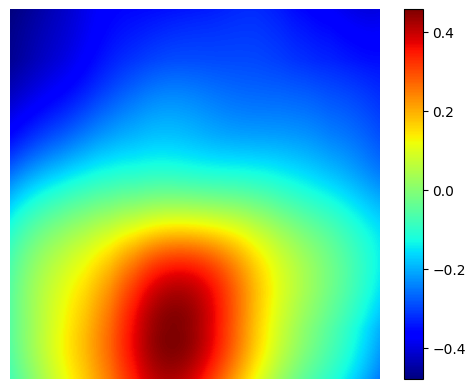

voc_class: dog
Deletion AUC    : 0.0007048045386836169
Insertion AUC   : 0.021852193121351147
Recall AUC      : 0.9491951011864075
Precision AUC   : 0.012506698616557406
F-Value AUC     : 0.012040116488849848


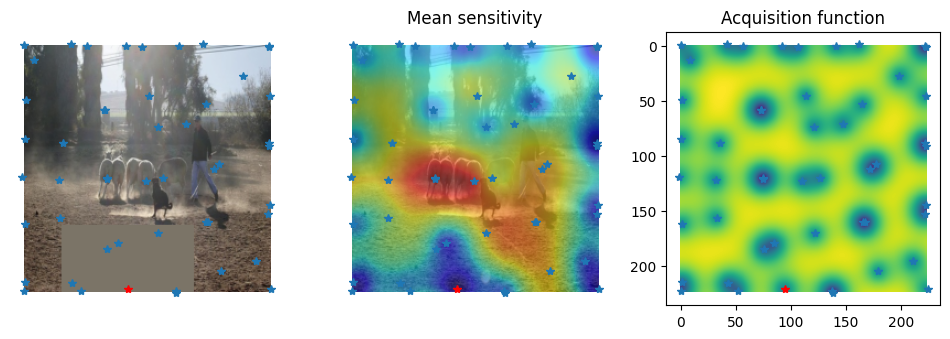

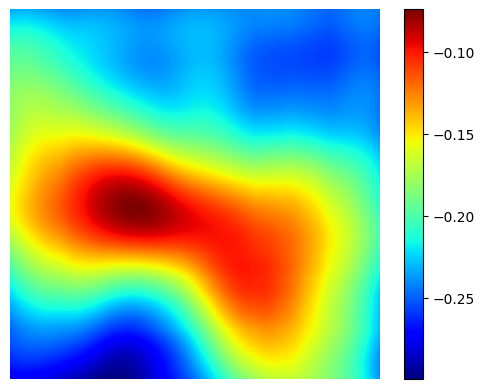

voc_class: bus
Deletion AUC    : 0.07946493549076535
Insertion AUC   : 0.7894738319948803
Recall AUC      : 0.7656424003429715
Precision AUC   : 0.4512573527194837
F-Value AUC     : 0.29989842408855827


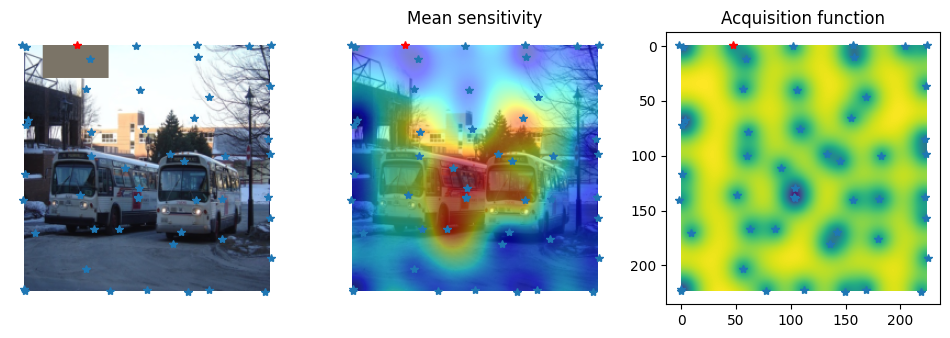

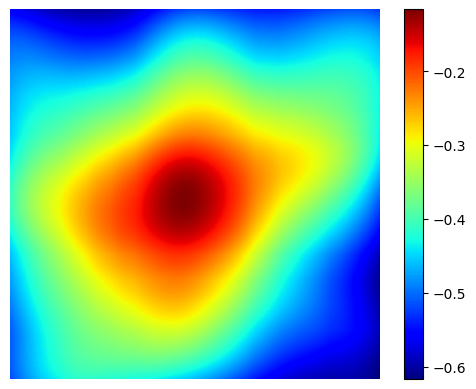

In [3]:
# Get list
file_list = glob.glob(fmt_annotation)
imagenet_dict = {}
with open(path_image_net) as f:
    for line in f.readlines():
        data = line.replace('\n', '').split(' ')
        imagenet_dict[int(data[0])] = data[1]

# BOREx
config = BorexConfig()
config.output_dir       = dir_output
config.iter_num         = 50
config.normalize        = True
config.sig_gain         = 10
config.aq_mean          = MeanType.NORMAL
config.ratio            = 10
config.mask_size_list   = [30, 45, 60, 75]
config.jitter           = [1, 1, 0.5]
config.is_save          = True
config.is_show          = True
# config = BorexConfig.load_yaml(path_config)   # able to load from yaml file

borex = Borex(config, img_size=224)

for i in range(start, start+count):
    # Get path
    xml_data = ET.parse(file_list[i]).getroot()
    base_name = xml_data.find("filename").text.split(".")[0]
    path_img = os.path.join(dir_image, base_name+".jpg")
    path_seg = os.path.join(dir_segmentation, base_name+".png")

    # Load image
    reader = TensorReader(size=borex.model.size)
    try:
        img         = reader.read_tensor(path_img)
        img_gcam    = reader.read_tensor_for_gcam(path_img)
        img_seg     = reader.read_tensor_for_seg(path_seg)
        label_ranking, prob_ranking = borex.model.get_top_n(img, 10)
    except:
        print(f"Load Error: {path_img}")
        continue

    # Get Class name
    class_name_list = []
    for name in xml_data.iter("object"):
        class_name = (name.find("name").text)
        if not class_name in class_name_list:
            if class_name != "person":
                class_name_list.append(class_name)
    top_class_name = get_class_name(label_ranking[0])

    # Gaussian Process Regressor
    gp  = GaussianProcessRegressor(kernel=Matern(length_scale_bounds=[1,20], length_scale=[12,12,10],nu=1.5), alpha=0.01)

    for voc_class in class_name_list:
        for class_idx in label_ranking:
            if not class_idx in imagenet_dict or not imagenet_dict[class_idx] == voc_class:
                continue
            pickle_path = f"{get_class_name(class_idx).replace(' ', '_')}.npy"
            method = SaliencyMethod.RISE

            # Generate saliency map
            sal_map = SaliencyMap.generate(borex, img, class_idx, method=SaliencyMethod.RISE)
            # sal_map = SaliencyMap.generate(borex, img_gcam, class_index, method=SaliencyMethod.GCAM)  # G-CAM method
            np.save(pickle_path, sal_map.sal)

            # Run
            result  = borex.run(img, img_seg, sal_map, gp, voc_class=voc_class)
            print(f"voc_class: {voc_class}")
            print(f"Deletion AUC    : {result.deletion}")
            print(f"Insertion AUC   : {result.insertion}")
            print(f"Recall AUC      : {result.recall}")
            print(f"Precision AUC   : {result.precision}")
            print(f"F-Value AUC     : {result.f_value}")
            plt.show()
            break